In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *

In [8]:
path = Path(base_dir)
path.ls()

[]

In [0]:
with open(base_dir + 'hello.txt', 'w') as f:
    f.write("Hello World")

## Multi-Label Prediction
The Planet Amazon dataset is a satellite image dataset. We first download this data from Kaggle. First, install the Kaggle API. Then, upload your credentials to the server. In Kaggle, go to My Account. Click on Create New API Token. Upload this to the server.

In [10]:
!pip install kaggle

In [22]:
!ls gdrive/"My Drive"/fastai-v3

hello.txt  kaggle.json


In [0]:
!mkdir -p ~/.kaggle/
!mv gdrive/"My Drive"/fastai-v3/kaggle.json /root/.kaggle

In [18]:
!ls /root/.kaggle

fastai-v3


Go to [the competition webpage](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) and accept its rules.

In [16]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True, parents=True)
print(path)

/root/.fastai/data/planet


In [25]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 98% 590M/600M [00:07<00:00, 34.5MB/s]
100% 600M/600M [00:08<00:00, 78.2MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 58.7MB/s]


In [26]:
!apt install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
!7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

In [28]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


We use the [data block API](https://docs.fast.ai/data_block.html), which gives flexibility over how to import the data. There are several classes to know about.
* The `Dataset` class in PyTorch (`torch.utils.data.Dataset`).
* To create mini-batches, you use a PyTorch class called `torch.utils.data.DataLoader`.
* The `DataBunch` class in `fastai` lets you bind together a training, validation, and optionally, a test `DataLoader` to feed to the model.

So what the code below is saying is this is where the data is coming from, this is where the labels are coming from, the labels are separated by a space, and create two separate datasets, training and validation. Then you create a `DataBunch`.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

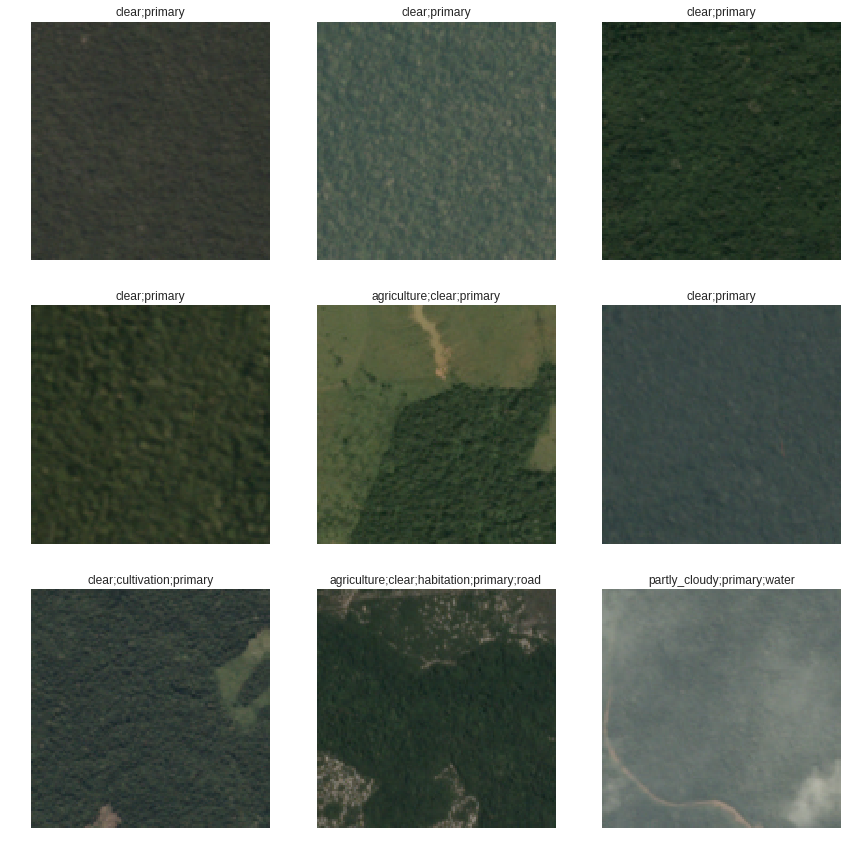

In [32]:
data.show_batch(rows=3)

This time our metrics will be a little different. We use `accuracy_thresh` instead of `accuracy`. Here, each activation can be 0 or 1, and we cannot use argmax because it's multi-label classification. `accuracy_thresh` selects labels that are above a threshold (0.5 is default). fbeta is the one used by Kaggle for this competition.

In [33]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89144749.12it/s]


In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


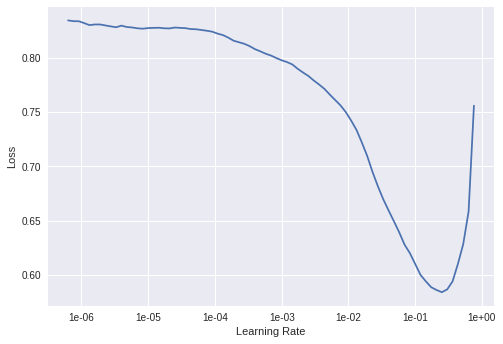

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, max_lr=slice(1e-2, 1e-1))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.167601,0.184067,0.906108,0.871690
2,0.184024,0.809341,0.928344,0.878235
3,0.139858,0.654581,0.954983,0.890887
4,0.111453,0.101271,0.956851,0.914592
5,0.099071,0.088338,0.956146,0.923733


In [0]:
learn.save('stage-1')

In [0]:
!cp /root/.fastai/data/planet/models/stage-1.pth gdrive/"My Drive"/fastai-v3/l3_multi.pth

In [0]:
learn.unfreeze()

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


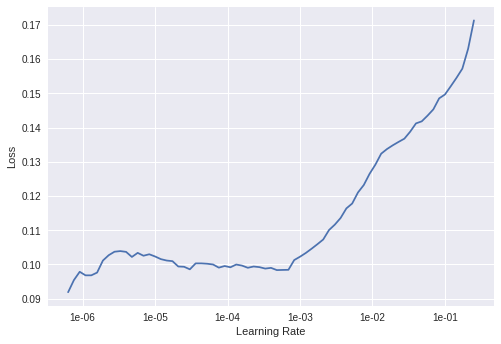

In [41]:
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.093269,0.086329,0.956524,0.924963
2,0.093058,0.104007,0.957243,0.925478
3,0.092429,0.216207,0.956386,0.925362
4,0.092474,0.112350,0.957337,0.926194
5,0.091208,0.097947,0.957657,0.926501


We want to be in the top 10% in the Kaggle competition, which is an fbeta of 0.92915. If you look back, our model uses images of 128 x 128, while the original data is 256 x 256. We now use transfer learning. This approach is quicker, because training initially on the 128 x 128 images is faster, and transfer learning can be quickly performed.

In [0]:
data = (src.transform(tfms, size=256)
           .databunch()
           .normalize(imagenet_stats))

In [0]:
learn.data = data

In [0]:
learn.freeze()

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


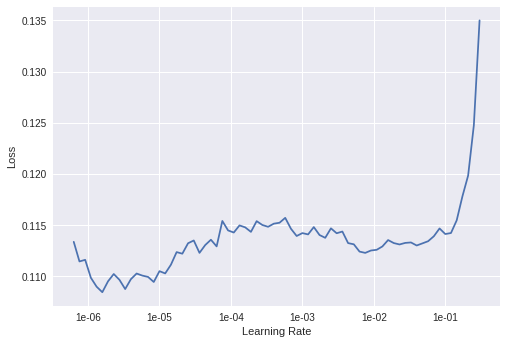

In [49]:
learn.recorder.plot()

In [50]:
lr = 1e-2 / 2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.099405,0.103991,0.953617,0.918975
2,0.096917,0.094539,0.955492,0.921507
3,0.093449,0.120401,0.958616,0.923306
4,0.091210,0.088935,0.957941,0.925385
5,0.089432,0.086161,0.957381,0.925041


In [0]:
learn.unfreeze()

In [52]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


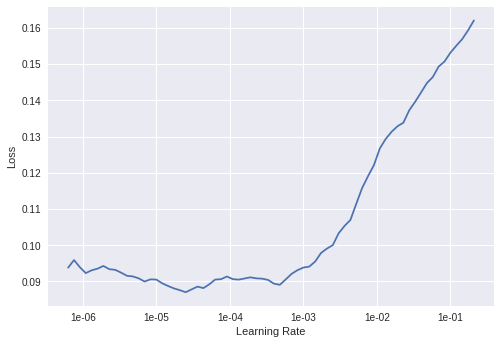

In [53]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.090374,0.118175,0.957490,0.924820
2,0.093199,0.087831,0.957272,0.926000
3,0.091447,0.088934,0.957650,0.926432
4,0.089534,0.087144,0.958239,0.925357
